### 이 파일이 이미지로 점수 예측하는 코드입니다. 

# 0. 실행할 부분

In [1]:
# torchvision 관련 라이브러리 import

from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

/nfs/home/dailyavenger/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install jsonlines
!pip install pdf2image

In [3]:
#@title

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models



In [4]:
#@title
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import glob
from PIL import Image
import jsonlines
import os
from tqdm import tqdm

#1. 데이터셋 로드


In [5]:
#@title
import cv2,io

class PaperDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        years = ["2021"]
        for year in years:
            cnt = 0
            year_image_path = overall_image_path
            # year_image_path = overall_image_path+"iclr"+year+"/"
            # *********** 경로 수정 ***********
            with jsonlines.open(f"iclr{year}_metadata.jsonl") as read_file:
                for line in read_file.iter():
                    rating_dict[line['forum']] = line['rating']
            input_paths = os.listdir(year_image_path)
            for one_file_image_path in tqdm(input_paths, desc="make data set"):
               
                image_path = year_image_path + one_file_image_path + "/"
                rating = rating_dict[one_file_image_path]
                
                before_add_size = len(self.image_list)
                self.image_list.extend(glob.glob(image_path + "*.bin")) # glob: 폴더 내의 파일 찾아줌   
                self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
                cnt += len(self.image_list)-before_add_size
                
            print(f"{year}: {cnt}")

    def __len__(self):
        return len(self.image_list)


    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 

        

        if self.transform is not None:
            img = self.transform(img)
        
        return img, label

In [6]:
image_path =  "../wngusrud27/dataset/image/iclr2021_cut/" 
image_path2 =  "temp/" 
dataset_file_name = 'iclr2021_dataset.pt'

In [7]:
#zip_path = image_path + "iclr2021_binary.zip"

#!mkdir binary

#!cp {zip_path} ./iclr2021.zip

#!unzip -q ./iclr2021.zip -d ./binary/ 

#!rm ./iclr2021.zip

In [8]:
def make_save_data_set(image_path2, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = PaperDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, image_path2 + dataset_file_name)
  print("save data sets")

In [9]:
#image_path =  "./binary/" 
make_save_data_set(image_path2, dataset_file_name)
# data_set_usage_ex(dataset_file_name)

start to make data set
initialize data sets


make data set: 100%|██████████| 2594/2594 [00:00<00:00, 4460.59it/s]


2021: 20752
data set length: 20752
save data sets


In [10]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(image_path2+dataset_file_name)

train_size = int(0.8 * len(dataset))
print("train size:", train_size)

test_size = len(dataset) - train_size
print("test size:", test_size)
# validation 
train_dataset, test_dataset = random_split(dataset, [train_size,test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

train size: 16601
test size: 4151


# 2 모델 생성,하이퍼 파라미터 설정

In [11]:
from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=False).to(device) # true 옵션으로 사전 학습된 모델을 로드

# transfer learning 사용 시 추가 
# if using_transfer_learning:|
#   for param in resnet50.parameters():
#     param.requires_grad = False

def create_model(input_channel, using_transfer_learning=True):
  
  assert(input_channel % 3 == 0, "The number of channels needs to be a multiple of 3")
  resnet50 = models.resnet50(pretrained=using_transfer_learning).to(device)
  if input_channel != 3:
    old_layer = resnet50.conv1
    
    # Creating a new Conv2d layer
    new_layer = nn.Conv2d(in_channels=input_channel, # 3 -> input_channel
                      out_channels=old_layer.out_channels, # 64
                      kernel_size=old_layer.kernel_size, # (7, 7)
                      stride=old_layer.stride, # (2, 2)
                      padding=old_layer.padding, # (3, 3)
                      bias=old_layer.bias) # False
    if using_transfer_learning:
      for channel in range(3, input_channel, 3):
        new_layer.weight[:, channel:channel+3, :, :] = old_layer.weight[:, 0:3, : :].clone()
    with torch.no_grad():
      # Copying the weights from the old to the new layer
      new_layer.weight[:, 0:3, :, :] = old_layer.weight.clone()
      
    new_layer.weight = nn.Parameter(new_layer.weight, requires_grad=(not using_transfer_learning))
  
    resnet50.conv1 = new_layer
  if using_transfer_learning:
    for param in resnet50.parameters():
      param.requires_grad = False
  # model = nn.Sequential(
  #     resnet50,
  #     nn.Flatten(),
  #     nn.Linear(1000, 256),
  #     nn.ReLU(),
  #     nn.Linear(256, 32),
  #     nn.ReLU(),
  #     nn.Linear(32, 1)
  # ).to(device)
  old_fc_in_features = resnet50.fc.in_features # = 2048
  resnet50.fc = nn.Linear(old_fc_in_features, 1)
  return resnet50.to(device)
  # return model


<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_3594330/4267760019.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(input_channel % 3 == 0, "The number of channels needs to be a multiple of 3")


In [12]:
import torch
import torch.nn as nn
from torch import optim
lr = 0.0001
num_epochs = 50
model=create_model(3,False)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)

In [13]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'test_dataloader': test_dataloader,
    'device':device
}

# 3. 학습

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [15]:
import time
import datetime
from numpy import vstack

def train(model, params):
  total_start = time.time()
  loss_function=params["loss_function"]
  train_dataloader=params["train_dataloader"]
  test_dataloader=params["test_dataloader"]
  device=params["device"]

  print("start train")
  print("train size:", train_size)
  print("test size:", test_size)
  min_loss=999999
  average_total=0
  average_accuracy=0
  for epoch in range(0, num_epochs):

    model.train()
    epoch_start = time.time()
    trained_number = 0
    for i, data in enumerate(train_dataloader, 0):
        
        # train dataloader 로 불러온 데이터에서 이미지와 라벨을 분리
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        
        # 이전 batch에서 계산된 가중치를 초기화
      optimizer.zero_grad() 
        # forward + back propagation 연산
      outputs = model(inputs).squeeze()
      train_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32))
      train_loss.backward()
      optimizer.step()
      trained_number += labels.size(0)
        
      if i%100==0:
        print(f"epoch {epoch+1} {trained_number/train_size*100}% train finish")
    print(f"epoch {epoch+1} train finish") 

  

    model.eval()
      # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    correct2 = 0 
    
    score_list = list()   ##새로 추가
    predict_list = list()
    

    for i, data in enumerate(test_dataloader, 0):
        
      inputs, labels = data        
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        

        # 결과값 연산
      outputs = model(inputs).squeeze()
      score_list.extend(labels.detach().cpu().numpy()) ##새로 추가
      predict_list.extend(outputs.detach().cpu().numpy())## 새로추가

      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      correct2 += (abs(outputs - labels)).sum().item()
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss
      if i%50==0:
        print(f"epoch {epoch+1} {total/test_size*100}% test finish")
        # break
    
    import matplotlib.pyplot as plt ##새로 추가
    plt.scatter(score_list,predict_list) ##새로 추가 .numpy()
    plt.xlabel('evaluation score')
    plt.ylabel('predicted score')
    plt.show()
    plt.close()
      # 학습 결과 출력
    print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f, difference: %.6f' %(epoch+1, num_epochs, train_loss.item(), loss/total, 100*correct/total, correct2/total)) #, correct2/total
    average_total+= loss/total
    average_accuracy+=100*correct/total
    if(min_loss > loss/total):
      min_loss=loss/total
      torch.save(model.state_dict(), f"temp/model{epoch}" )

  average_total/=num_epochs 
  average_accuracy/=num_epochs
  print("min loss:", min_loss)
  print("average_loss:", average_total)
  print("average_accuracy:", average_accuracy)    
    #epoch_elapsed_time = time.time() - epoch_start
    #epoch_elapsed_time_list = str(datetime.timedelta(seconds=epoch_elapsed_time)).split(".")
    #total_elapsed_time = time.time() - total_start
    #total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    #print(f"Epoch {epoch+1} Elapsed time is {epoch_elapsed_time_list[0]}")  
    #print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  


start train
train size: 16601
test size: 4151
epoch 1 0.09637973616047225% train finish


/tmp/ipykernel_3594330/2920515390.py:43: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(data, dtype=np.uint8)


epoch 1 9.734353352207698% train finish
epoch 1 19.372326968254924% train finish
epoch 1 29.01030058430215% train finish
epoch 1 38.64827420034938% train finish
epoch 1 48.2862478163966% train finish
epoch 1 57.92422143244382% train finish
epoch 1 67.56219504849106% train finish
epoch 1 77.20016866453828% train finish
epoch 1 86.8381422805855% train finish
epoch 1 96.47611589663273% train finish
epoch 1 train finish
epoch 1 0.3854492893278728% test finish
epoch 1 19.657913755721513% test finish
epoch 1 38.93037822211515% test finish
epoch 1 58.202842688508795% test finish
epoch 1 77.47530715490242% test finish
epoch 1 96.74777162129608% test finish


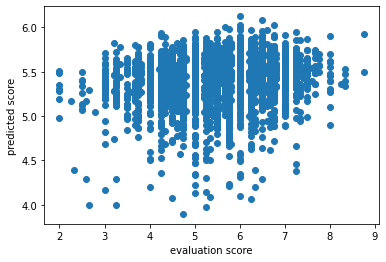

Epoch: 1/50, Train loss: 0.906590, Test loss: 0.997577, Accuracy: 37.00, difference: 0.803410
epoch 2 0.09637973616047225% train finish
epoch 2 9.734353352207698% train finish
epoch 2 19.372326968254924% train finish
epoch 2 29.01030058430215% train finish
epoch 2 38.64827420034938% train finish
epoch 2 48.2862478163966% train finish
epoch 2 57.92422143244382% train finish
epoch 2 67.56219504849106% train finish
epoch 2 77.20016866453828% train finish
epoch 2 86.8381422805855% train finish
epoch 2 96.47611589663273% train finish
epoch 2 train finish
epoch 2 0.3854492893278728% test finish
epoch 2 19.657913755721513% test finish
epoch 2 38.93037822211515% test finish
epoch 2 58.202842688508795% test finish
epoch 2 77.47530715490242% test finish
epoch 2 96.74777162129608% test finish


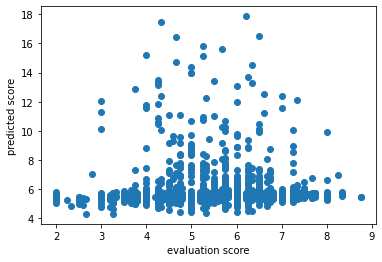

Epoch: 2/50, Train loss: 1.455720, Test loss: 1.860613, Accuracy: 37.05, difference: 0.913599
epoch 3 0.09637973616047225% train finish
epoch 3 9.734353352207698% train finish
epoch 3 19.372326968254924% train finish
epoch 3 29.01030058430215% train finish
epoch 3 38.64827420034938% train finish
epoch 3 48.2862478163966% train finish
epoch 3 57.92422143244382% train finish
epoch 3 67.56219504849106% train finish
epoch 3 77.20016866453828% train finish
epoch 3 86.8381422805855% train finish
epoch 3 96.47611589663273% train finish
epoch 3 train finish
epoch 3 0.3854492893278728% test finish
epoch 3 19.657913755721513% test finish
epoch 3 38.93037822211515% test finish
epoch 3 58.202842688508795% test finish
epoch 3 77.47530715490242% test finish
epoch 3 96.74777162129608% test finish


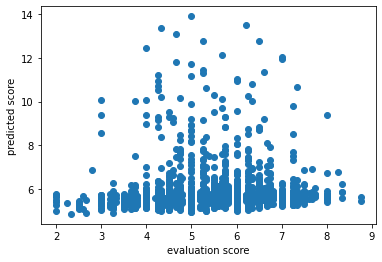

Epoch: 3/50, Train loss: 0.321065, Test loss: 1.479162, Accuracy: 37.17, difference: 0.879541
epoch 4 0.09637973616047225% train finish
epoch 4 9.734353352207698% train finish
epoch 4 19.372326968254924% train finish
epoch 4 29.01030058430215% train finish
epoch 4 38.64827420034938% train finish
epoch 4 48.2862478163966% train finish
epoch 4 57.92422143244382% train finish
epoch 4 67.56219504849106% train finish
epoch 4 77.20016866453828% train finish
epoch 4 86.8381422805855% train finish
epoch 4 96.47611589663273% train finish
epoch 4 train finish
epoch 4 0.3854492893278728% test finish
epoch 4 19.657913755721513% test finish
epoch 4 38.93037822211515% test finish
epoch 4 58.202842688508795% test finish
epoch 4 77.47530715490242% test finish
epoch 4 96.74777162129608% test finish


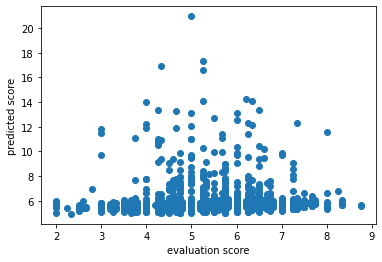

Epoch: 4/50, Train loss: 0.659840, Test loss: 1.743003, Accuracy: 37.73, difference: 0.900404
epoch 5 0.09637973616047225% train finish
epoch 5 9.734353352207698% train finish
epoch 5 19.372326968254924% train finish
epoch 5 29.01030058430215% train finish
epoch 5 38.64827420034938% train finish
epoch 5 48.2862478163966% train finish
epoch 5 57.92422143244382% train finish
epoch 5 67.56219504849106% train finish
epoch 5 77.20016866453828% train finish
epoch 5 86.8381422805855% train finish
epoch 5 96.47611589663273% train finish
epoch 5 train finish
epoch 5 0.3854492893278728% test finish
epoch 5 19.657913755721513% test finish
epoch 5 38.93037822211515% test finish
epoch 5 58.202842688508795% test finish
epoch 5 77.47530715490242% test finish
epoch 5 96.74777162129608% test finish


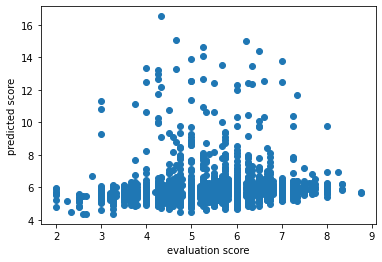

Epoch: 5/50, Train loss: 1.002810, Test loss: 1.764462, Accuracy: 37.20, difference: 0.918029
epoch 6 0.09637973616047225% train finish
epoch 6 9.734353352207698% train finish
epoch 6 19.372326968254924% train finish
epoch 6 29.01030058430215% train finish
epoch 6 38.64827420034938% train finish
epoch 6 48.2862478163966% train finish
epoch 6 57.92422143244382% train finish
epoch 6 67.56219504849106% train finish
epoch 6 77.20016866453828% train finish
epoch 6 86.8381422805855% train finish
epoch 6 96.47611589663273% train finish
epoch 6 train finish
epoch 6 0.3854492893278728% test finish
epoch 6 19.657913755721513% test finish
epoch 6 38.93037822211515% test finish
epoch 6 58.202842688508795% test finish
epoch 6 77.47530715490242% test finish
epoch 6 96.74777162129608% test finish


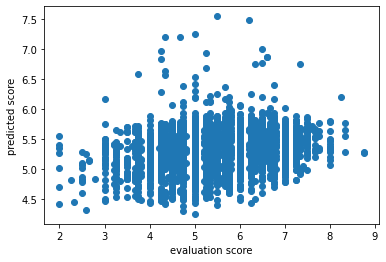

Epoch: 6/50, Train loss: 0.520058, Test loss: 0.990417, Accuracy: 36.83, difference: 0.803226
epoch 7 0.09637973616047225% train finish
epoch 7 9.734353352207698% train finish
epoch 7 19.372326968254924% train finish
epoch 7 29.01030058430215% train finish
epoch 7 38.64827420034938% train finish
epoch 7 48.2862478163966% train finish
epoch 7 57.92422143244382% train finish
epoch 7 67.56219504849106% train finish
epoch 7 77.20016866453828% train finish
epoch 7 86.8381422805855% train finish
epoch 7 96.47611589663273% train finish
epoch 7 train finish
epoch 7 0.3854492893278728% test finish
epoch 7 19.657913755721513% test finish
epoch 7 38.93037822211515% test finish
epoch 7 58.202842688508795% test finish
epoch 7 77.47530715490242% test finish
epoch 7 96.74777162129608% test finish


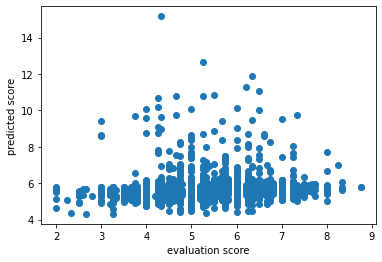

Epoch: 7/50, Train loss: 1.519522, Test loss: 1.237078, Accuracy: 37.58, difference: 0.842081
epoch 8 0.09637973616047225% train finish
epoch 8 9.734353352207698% train finish
epoch 8 19.372326968254924% train finish
epoch 8 29.01030058430215% train finish
epoch 8 38.64827420034938% train finish
epoch 8 48.2862478163966% train finish
epoch 8 57.92422143244382% train finish
epoch 8 67.56219504849106% train finish
epoch 8 77.20016866453828% train finish
epoch 8 86.8381422805855% train finish
epoch 8 96.47611589663273% train finish
epoch 8 train finish
epoch 8 0.3854492893278728% test finish
epoch 8 19.657913755721513% test finish
epoch 8 38.93037822211515% test finish
epoch 8 58.202842688508795% test finish
epoch 8 77.47530715490242% test finish
epoch 8 96.74777162129608% test finish


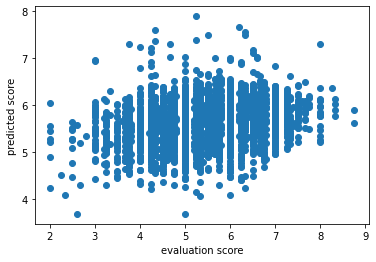

Epoch: 8/50, Train loss: 1.097049, Test loss: 1.009689, Accuracy: 38.18, difference: 0.800951
epoch 9 0.09637973616047225% train finish
epoch 9 9.734353352207698% train finish
epoch 9 19.372326968254924% train finish
epoch 9 29.01030058430215% train finish
epoch 9 38.64827420034938% train finish
epoch 9 48.2862478163966% train finish
epoch 9 57.92422143244382% train finish
epoch 9 67.56219504849106% train finish
epoch 9 77.20016866453828% train finish
epoch 9 86.8381422805855% train finish
epoch 9 96.47611589663273% train finish
epoch 9 train finish
epoch 9 0.3854492893278728% test finish
epoch 9 19.657913755721513% test finish
epoch 9 38.93037822211515% test finish
epoch 9 58.202842688508795% test finish
epoch 9 77.47530715490242% test finish
epoch 9 96.74777162129608% test finish


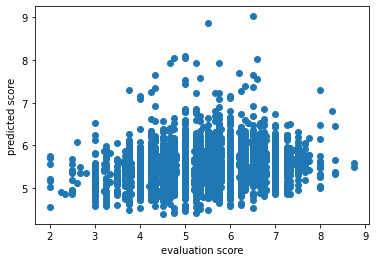

Epoch: 9/50, Train loss: 0.751213, Test loss: 1.046646, Accuracy: 37.10, difference: 0.817150
epoch 10 0.09637973616047225% train finish
epoch 10 9.734353352207698% train finish
epoch 10 19.372326968254924% train finish
epoch 10 29.01030058430215% train finish
epoch 10 38.64827420034938% train finish
epoch 10 48.2862478163966% train finish
epoch 10 57.92422143244382% train finish
epoch 10 67.56219504849106% train finish
epoch 10 77.20016866453828% train finish
epoch 10 86.8381422805855% train finish
epoch 10 96.47611589663273% train finish
epoch 10 train finish
epoch 10 0.3854492893278728% test finish
epoch 10 19.657913755721513% test finish
epoch 10 38.93037822211515% test finish
epoch 10 58.202842688508795% test finish
epoch 10 77.47530715490242% test finish
epoch 10 96.74777162129608% test finish


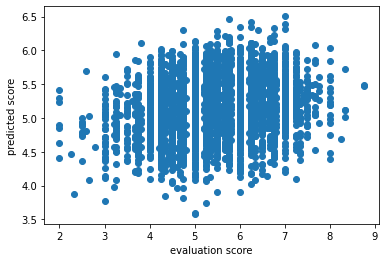

Epoch: 10/50, Train loss: 1.077964, Test loss: 1.125070, Accuracy: 34.23, difference: 0.857401
epoch 11 0.09637973616047225% train finish
epoch 11 9.734353352207698% train finish
epoch 11 19.372326968254924% train finish
epoch 11 29.01030058430215% train finish
epoch 11 38.64827420034938% train finish
epoch 11 48.2862478163966% train finish
epoch 11 57.92422143244382% train finish
epoch 11 67.56219504849106% train finish
epoch 11 77.20016866453828% train finish
epoch 11 86.8381422805855% train finish
epoch 11 96.47611589663273% train finish
epoch 11 train finish
epoch 11 0.3854492893278728% test finish
epoch 11 19.657913755721513% test finish
epoch 11 38.93037822211515% test finish
epoch 11 58.202842688508795% test finish
epoch 11 77.47530715490242% test finish
epoch 11 96.74777162129608% test finish


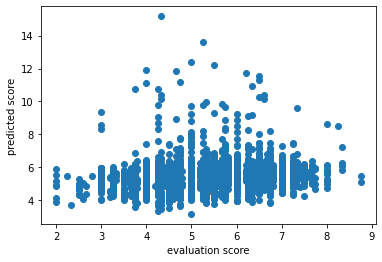

Epoch: 11/50, Train loss: 0.612180, Test loss: 1.405523, Accuracy: 35.58, difference: 0.894711
epoch 12 0.09637973616047225% train finish
epoch 12 9.734353352207698% train finish
epoch 12 19.372326968254924% train finish
epoch 12 29.01030058430215% train finish
epoch 12 38.64827420034938% train finish
epoch 12 48.2862478163966% train finish
epoch 12 57.92422143244382% train finish
epoch 12 67.56219504849106% train finish
epoch 12 77.20016866453828% train finish
epoch 12 86.8381422805855% train finish
epoch 12 96.47611589663273% train finish
epoch 12 train finish
epoch 12 0.3854492893278728% test finish
epoch 12 19.657913755721513% test finish
epoch 12 38.93037822211515% test finish
epoch 12 58.202842688508795% test finish
epoch 12 77.47530715490242% test finish
epoch 12 96.74777162129608% test finish


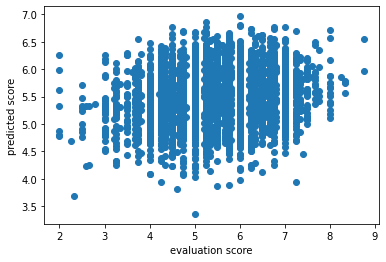

Epoch: 12/50, Train loss: 0.248123, Test loss: 1.068158, Accuracy: 35.44, difference: 0.835659
epoch 13 0.09637973616047225% train finish
epoch 13 9.734353352207698% train finish
epoch 13 19.372326968254924% train finish
epoch 13 29.01030058430215% train finish
epoch 13 38.64827420034938% train finish
epoch 13 48.2862478163966% train finish
epoch 13 57.92422143244382% train finish
epoch 13 67.56219504849106% train finish
epoch 13 77.20016866453828% train finish
epoch 13 86.8381422805855% train finish
epoch 13 96.47611589663273% train finish
epoch 13 train finish
epoch 13 0.3854492893278728% test finish
epoch 13 19.657913755721513% test finish
epoch 13 38.93037822211515% test finish
epoch 13 58.202842688508795% test finish
epoch 13 77.47530715490242% test finish
epoch 13 96.74777162129608% test finish


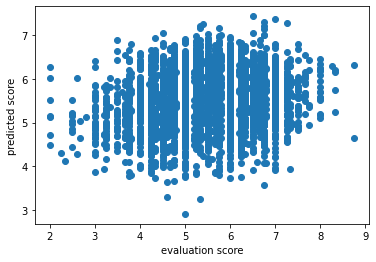

Epoch: 13/50, Train loss: 0.256066, Test loss: 1.152405, Accuracy: 35.10, difference: 0.860913
epoch 14 0.09637973616047225% train finish
epoch 14 9.734353352207698% train finish
epoch 14 19.372326968254924% train finish
epoch 14 29.01030058430215% train finish
epoch 14 38.64827420034938% train finish
epoch 14 48.2862478163966% train finish
epoch 14 57.92422143244382% train finish
epoch 14 67.56219504849106% train finish
epoch 14 77.20016866453828% train finish
epoch 14 86.8381422805855% train finish
epoch 14 96.47611589663273% train finish
epoch 14 train finish
epoch 14 0.3854492893278728% test finish
epoch 14 19.657913755721513% test finish
epoch 14 38.93037822211515% test finish
epoch 14 58.202842688508795% test finish
epoch 14 77.47530715490242% test finish
epoch 14 96.74777162129608% test finish


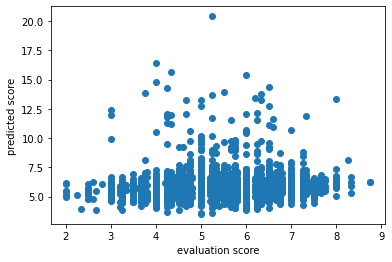

Epoch: 14/50, Train loss: 0.316132, Test loss: 2.059286, Accuracy: 32.04, difference: 1.011268
epoch 15 0.09637973616047225% train finish
epoch 15 9.734353352207698% train finish
epoch 15 19.372326968254924% train finish
epoch 15 29.01030058430215% train finish
epoch 15 38.64827420034938% train finish
epoch 15 48.2862478163966% train finish
epoch 15 57.92422143244382% train finish
epoch 15 67.56219504849106% train finish
epoch 15 77.20016866453828% train finish
epoch 15 86.8381422805855% train finish
epoch 15 96.47611589663273% train finish
epoch 15 train finish
epoch 15 0.3854492893278728% test finish
epoch 15 19.657913755721513% test finish
epoch 15 38.93037822211515% test finish
epoch 15 58.202842688508795% test finish
epoch 15 77.47530715490242% test finish
epoch 15 96.74777162129608% test finish


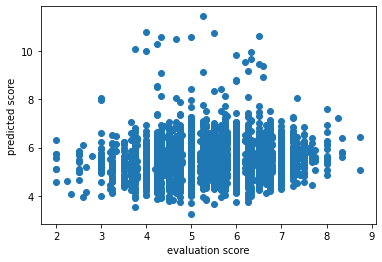

Epoch: 15/50, Train loss: 0.346638, Test loss: 1.347561, Accuracy: 34.76, difference: 0.903529
epoch 16 0.09637973616047225% train finish
epoch 16 9.734353352207698% train finish
epoch 16 19.372326968254924% train finish
epoch 16 29.01030058430215% train finish
epoch 16 38.64827420034938% train finish
epoch 16 48.2862478163966% train finish
epoch 16 57.92422143244382% train finish
epoch 16 67.56219504849106% train finish
epoch 16 77.20016866453828% train finish
epoch 16 86.8381422805855% train finish
epoch 16 96.47611589663273% train finish
epoch 16 train finish
epoch 16 0.3854492893278728% test finish
epoch 16 19.657913755721513% test finish
epoch 16 38.93037822211515% test finish
epoch 16 58.202842688508795% test finish
epoch 16 77.47530715490242% test finish
epoch 16 96.74777162129608% test finish


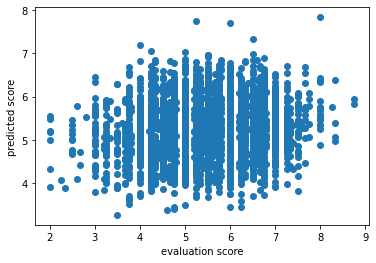

Epoch: 16/50, Train loss: 0.244995, Test loss: 1.254845, Accuracy: 33.51, difference: 0.902659
epoch 17 0.09637973616047225% train finish
epoch 17 9.734353352207698% train finish
epoch 17 19.372326968254924% train finish
epoch 17 29.01030058430215% train finish
epoch 17 38.64827420034938% train finish
epoch 17 48.2862478163966% train finish
epoch 17 57.92422143244382% train finish
epoch 17 67.56219504849106% train finish
epoch 17 77.20016866453828% train finish
epoch 17 86.8381422805855% train finish
epoch 17 96.47611589663273% train finish
epoch 17 train finish
epoch 17 0.3854492893278728% test finish
epoch 17 19.657913755721513% test finish
epoch 17 38.93037822211515% test finish
epoch 17 58.202842688508795% test finish
epoch 17 77.47530715490242% test finish
epoch 17 96.74777162129608% test finish


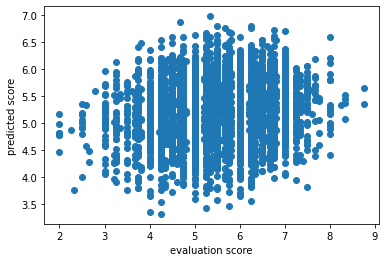

Epoch: 17/50, Train loss: 0.186415, Test loss: 1.216419, Accuracy: 34.26, difference: 0.884823
epoch 18 0.09637973616047225% train finish
epoch 18 9.734353352207698% train finish
epoch 18 19.372326968254924% train finish
epoch 18 29.01030058430215% train finish
epoch 18 38.64827420034938% train finish
epoch 18 48.2862478163966% train finish
epoch 18 57.92422143244382% train finish
epoch 18 67.56219504849106% train finish
epoch 18 77.20016866453828% train finish
epoch 18 86.8381422805855% train finish
epoch 18 96.47611589663273% train finish
epoch 18 train finish
epoch 18 0.3854492893278728% test finish
epoch 18 19.657913755721513% test finish
epoch 18 38.93037822211515% test finish
epoch 18 58.202842688508795% test finish
epoch 18 77.47530715490242% test finish
epoch 18 96.74777162129608% test finish


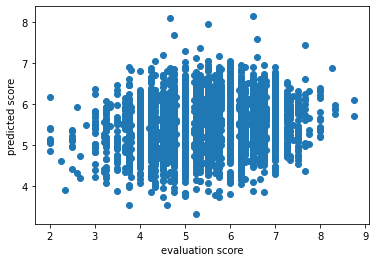

Epoch: 18/50, Train loss: 0.211147, Test loss: 1.163055, Accuracy: 35.89, difference: 0.860683
epoch 19 0.09637973616047225% train finish
epoch 19 9.734353352207698% train finish
epoch 19 19.372326968254924% train finish
epoch 19 29.01030058430215% train finish
epoch 19 38.64827420034938% train finish
epoch 19 48.2862478163966% train finish
epoch 19 57.92422143244382% train finish
epoch 19 67.56219504849106% train finish
epoch 19 77.20016866453828% train finish
epoch 19 86.8381422805855% train finish
epoch 19 96.47611589663273% train finish
epoch 19 train finish
epoch 19 0.3854492893278728% test finish
epoch 19 19.657913755721513% test finish
epoch 19 38.93037822211515% test finish
epoch 19 58.202842688508795% test finish
epoch 19 77.47530715490242% test finish
epoch 19 96.74777162129608% test finish


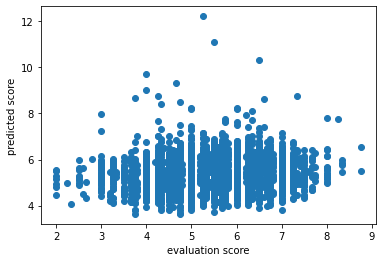

Epoch: 19/50, Train loss: 0.154040, Test loss: 1.256377, Accuracy: 34.45, difference: 0.885728
epoch 20 0.09637973616047225% train finish
epoch 20 9.734353352207698% train finish
epoch 20 19.372326968254924% train finish
epoch 20 29.01030058430215% train finish
epoch 20 38.64827420034938% train finish
epoch 20 48.2862478163966% train finish
epoch 20 57.92422143244382% train finish
epoch 20 67.56219504849106% train finish
epoch 20 77.20016866453828% train finish
epoch 20 86.8381422805855% train finish
epoch 20 96.47611589663273% train finish
epoch 20 train finish
epoch 20 0.3854492893278728% test finish
epoch 20 19.657913755721513% test finish
epoch 20 38.93037822211515% test finish
epoch 20 58.202842688508795% test finish
epoch 20 77.47530715490242% test finish
epoch 20 96.74777162129608% test finish


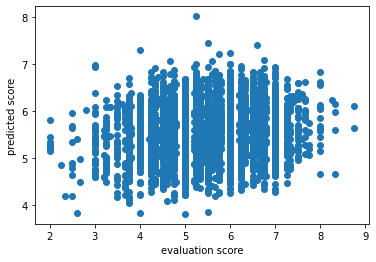

Epoch: 20/50, Train loss: 0.049894, Test loss: 1.131541, Accuracy: 35.24, difference: 0.852222
epoch 21 0.09637973616047225% train finish
epoch 21 9.734353352207698% train finish
epoch 21 19.372326968254924% train finish
epoch 21 29.01030058430215% train finish
epoch 21 38.64827420034938% train finish
epoch 21 48.2862478163966% train finish
epoch 21 57.92422143244382% train finish
epoch 21 67.56219504849106% train finish
epoch 21 77.20016866453828% train finish
epoch 21 86.8381422805855% train finish
epoch 21 96.47611589663273% train finish
epoch 21 train finish
epoch 21 0.3854492893278728% test finish
epoch 21 19.657913755721513% test finish
epoch 21 38.93037822211515% test finish
epoch 21 58.202842688508795% test finish
epoch 21 77.47530715490242% test finish
epoch 21 96.74777162129608% test finish


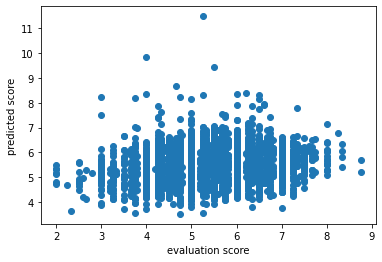

Epoch: 21/50, Train loss: 0.159716, Test loss: 1.194967, Accuracy: 34.21, difference: 0.871231
epoch 22 0.09637973616047225% train finish
epoch 22 9.734353352207698% train finish
epoch 22 19.372326968254924% train finish
epoch 22 29.01030058430215% train finish
epoch 22 38.64827420034938% train finish
epoch 22 48.2862478163966% train finish
epoch 22 57.92422143244382% train finish
epoch 22 67.56219504849106% train finish
epoch 22 77.20016866453828% train finish
epoch 22 86.8381422805855% train finish
epoch 22 96.47611589663273% train finish
epoch 22 train finish
epoch 22 0.3854492893278728% test finish
epoch 22 19.657913755721513% test finish
epoch 22 38.93037822211515% test finish
epoch 22 58.202842688508795% test finish
epoch 22 77.47530715490242% test finish
epoch 22 96.74777162129608% test finish


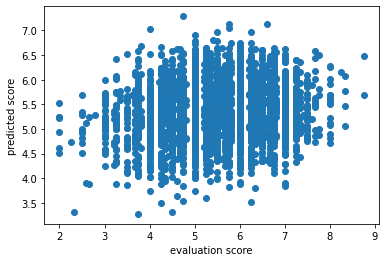

Epoch: 22/50, Train loss: 0.195232, Test loss: 1.132897, Accuracy: 35.65, difference: 0.853335
epoch 23 0.09637973616047225% train finish
epoch 23 9.734353352207698% train finish
epoch 23 19.372326968254924% train finish
epoch 23 29.01030058430215% train finish
epoch 23 38.64827420034938% train finish
epoch 23 48.2862478163966% train finish
epoch 23 57.92422143244382% train finish
epoch 23 67.56219504849106% train finish
epoch 23 77.20016866453828% train finish
epoch 23 86.8381422805855% train finish
epoch 23 96.47611589663273% train finish
epoch 23 train finish
epoch 23 0.3854492893278728% test finish
epoch 23 19.657913755721513% test finish
epoch 23 38.93037822211515% test finish
epoch 23 58.202842688508795% test finish
epoch 23 77.47530715490242% test finish
epoch 23 96.74777162129608% test finish


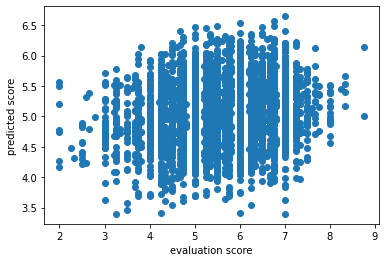

Epoch: 23/50, Train loss: 0.090821, Test loss: 1.286145, Accuracy: 32.74, difference: 0.915516
epoch 24 0.09637973616047225% train finish
epoch 24 9.734353352207698% train finish
epoch 24 19.372326968254924% train finish
epoch 24 29.01030058430215% train finish
epoch 24 38.64827420034938% train finish
epoch 24 48.2862478163966% train finish
epoch 24 57.92422143244382% train finish
epoch 24 67.56219504849106% train finish
epoch 24 77.20016866453828% train finish
epoch 24 86.8381422805855% train finish
epoch 24 96.47611589663273% train finish
epoch 24 train finish
epoch 24 0.3854492893278728% test finish
epoch 24 19.657913755721513% test finish
epoch 24 38.93037822211515% test finish
epoch 24 58.202842688508795% test finish
epoch 24 77.47530715490242% test finish
epoch 24 96.74777162129608% test finish


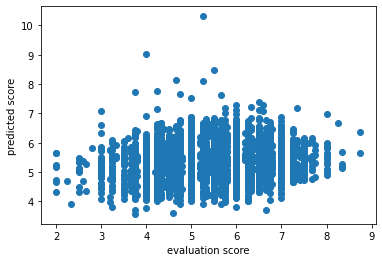

Epoch: 24/50, Train loss: 0.129718, Test loss: 1.174379, Accuracy: 35.70, difference: 0.862353
epoch 25 0.09637973616047225% train finish
epoch 25 9.734353352207698% train finish
epoch 25 19.372326968254924% train finish
epoch 25 29.01030058430215% train finish
epoch 25 38.64827420034938% train finish
epoch 25 48.2862478163966% train finish
epoch 25 57.92422143244382% train finish
epoch 25 67.56219504849106% train finish
epoch 25 77.20016866453828% train finish
epoch 25 86.8381422805855% train finish
epoch 25 96.47611589663273% train finish
epoch 25 train finish
epoch 25 0.3854492893278728% test finish
epoch 25 19.657913755721513% test finish
epoch 25 38.93037822211515% test finish
epoch 25 58.202842688508795% test finish
epoch 25 77.47530715490242% test finish
epoch 25 96.74777162129608% test finish


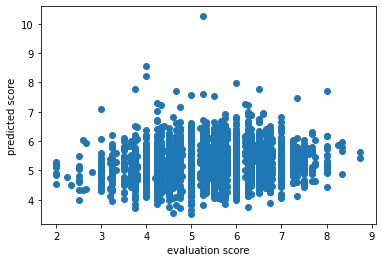

Epoch: 25/50, Train loss: 0.199310, Test loss: 1.194443, Accuracy: 34.83, difference: 0.874817
epoch 26 0.09637973616047225% train finish
epoch 26 9.734353352207698% train finish
epoch 26 19.372326968254924% train finish
epoch 26 29.01030058430215% train finish
epoch 26 38.64827420034938% train finish
epoch 26 48.2862478163966% train finish
epoch 26 57.92422143244382% train finish
epoch 26 67.56219504849106% train finish
epoch 26 77.20016866453828% train finish
epoch 26 86.8381422805855% train finish
epoch 26 96.47611589663273% train finish
epoch 26 train finish
epoch 26 0.3854492893278728% test finish
epoch 26 19.657913755721513% test finish
epoch 26 38.93037822211515% test finish
epoch 26 58.202842688508795% test finish
epoch 26 77.47530715490242% test finish
epoch 26 96.74777162129608% test finish


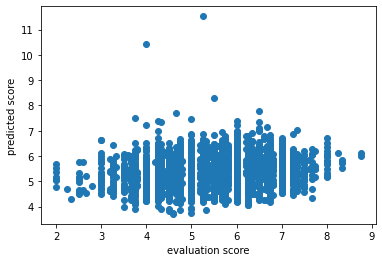

Epoch: 26/50, Train loss: 0.089293, Test loss: 1.120587, Accuracy: 35.82, difference: 0.843684
epoch 27 0.09637973616047225% train finish
epoch 27 9.734353352207698% train finish
epoch 27 19.372326968254924% train finish
epoch 27 29.01030058430215% train finish
epoch 27 38.64827420034938% train finish
epoch 27 48.2862478163966% train finish
epoch 27 57.92422143244382% train finish
epoch 27 67.56219504849106% train finish
epoch 27 77.20016866453828% train finish
epoch 27 86.8381422805855% train finish
epoch 27 96.47611589663273% train finish
epoch 27 train finish
epoch 27 0.3854492893278728% test finish
epoch 27 19.657913755721513% test finish
epoch 27 38.93037822211515% test finish
epoch 27 58.202842688508795% test finish
epoch 27 77.47530715490242% test finish
epoch 27 96.74777162129608% test finish


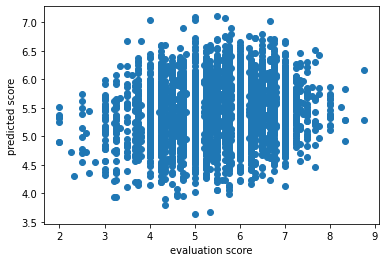

Epoch: 27/50, Train loss: 0.091133, Test loss: 1.099004, Accuracy: 35.24, difference: 0.842862
epoch 28 0.09637973616047225% train finish
epoch 28 9.734353352207698% train finish
epoch 28 19.372326968254924% train finish
epoch 28 29.01030058430215% train finish
epoch 28 38.64827420034938% train finish
epoch 28 48.2862478163966% train finish
epoch 28 57.92422143244382% train finish
epoch 28 67.56219504849106% train finish
epoch 28 77.20016866453828% train finish
epoch 28 86.8381422805855% train finish
epoch 28 96.47611589663273% train finish
epoch 28 train finish
epoch 28 0.3854492893278728% test finish
epoch 28 19.657913755721513% test finish
epoch 28 38.93037822211515% test finish
epoch 28 58.202842688508795% test finish
epoch 28 77.47530715490242% test finish
epoch 28 96.74777162129608% test finish


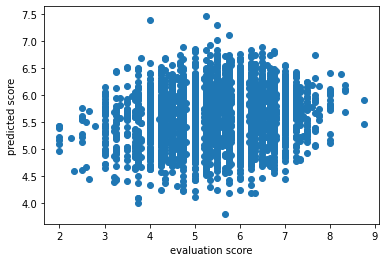

Epoch: 28/50, Train loss: 0.083050, Test loss: 1.066894, Accuracy: 37.20, difference: 0.825249
epoch 29 0.09637973616047225% train finish
epoch 29 9.734353352207698% train finish
epoch 29 19.372326968254924% train finish
epoch 29 29.01030058430215% train finish
epoch 29 38.64827420034938% train finish
epoch 29 48.2862478163966% train finish
epoch 29 57.92422143244382% train finish
epoch 29 67.56219504849106% train finish
epoch 29 77.20016866453828% train finish
epoch 29 86.8381422805855% train finish
epoch 29 96.47611589663273% train finish
epoch 29 train finish
epoch 29 0.3854492893278728% test finish
epoch 29 19.657913755721513% test finish
epoch 29 38.93037822211515% test finish
epoch 29 58.202842688508795% test finish
epoch 29 77.47530715490242% test finish
epoch 29 96.74777162129608% test finish


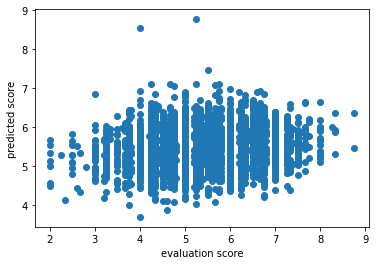

Epoch: 29/50, Train loss: 0.043440, Test loss: 1.073444, Accuracy: 37.08, difference: 0.827557
epoch 30 0.09637973616047225% train finish
epoch 30 9.734353352207698% train finish
epoch 30 19.372326968254924% train finish
epoch 30 29.01030058430215% train finish
epoch 30 38.64827420034938% train finish
epoch 30 48.2862478163966% train finish
epoch 30 57.92422143244382% train finish
epoch 30 67.56219504849106% train finish
epoch 30 77.20016866453828% train finish
epoch 30 86.8381422805855% train finish
epoch 30 96.47611589663273% train finish
epoch 30 train finish
epoch 30 0.3854492893278728% test finish
epoch 30 19.657913755721513% test finish
epoch 30 38.93037822211515% test finish
epoch 30 58.202842688508795% test finish
epoch 30 77.47530715490242% test finish
epoch 30 96.74777162129608% test finish


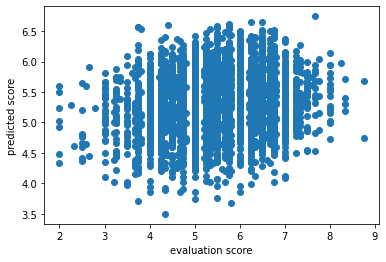

Epoch: 30/50, Train loss: 0.071267, Test loss: 1.129106, Accuracy: 35.51, difference: 0.855936
epoch 31 0.09637973616047225% train finish
epoch 31 9.734353352207698% train finish
epoch 31 19.372326968254924% train finish
epoch 31 29.01030058430215% train finish
epoch 31 38.64827420034938% train finish
epoch 31 48.2862478163966% train finish
epoch 31 57.92422143244382% train finish
epoch 31 67.56219504849106% train finish
epoch 31 77.20016866453828% train finish
epoch 31 86.8381422805855% train finish
epoch 31 96.47611589663273% train finish
epoch 31 train finish
epoch 31 0.3854492893278728% test finish
epoch 31 19.657913755721513% test finish
epoch 31 38.93037822211515% test finish
epoch 31 58.202842688508795% test finish
epoch 31 77.47530715490242% test finish
epoch 31 96.74777162129608% test finish


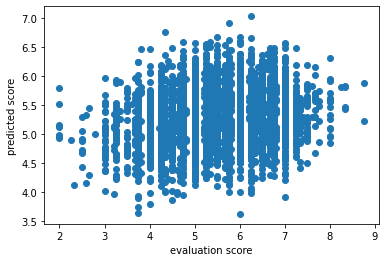

Epoch: 31/50, Train loss: 0.075616, Test loss: 1.092829, Accuracy: 35.24, difference: 0.844363
epoch 32 0.09637973616047225% train finish
epoch 32 9.734353352207698% train finish
epoch 32 19.372326968254924% train finish
epoch 32 29.01030058430215% train finish
epoch 32 38.64827420034938% train finish
epoch 32 48.2862478163966% train finish
epoch 32 57.92422143244382% train finish
epoch 32 67.56219504849106% train finish
epoch 32 77.20016866453828% train finish
epoch 32 86.8381422805855% train finish
epoch 32 96.47611589663273% train finish
epoch 32 train finish
epoch 32 0.3854492893278728% test finish
epoch 32 19.657913755721513% test finish
epoch 32 38.93037822211515% test finish
epoch 32 58.202842688508795% test finish
epoch 32 77.47530715490242% test finish
epoch 32 96.74777162129608% test finish


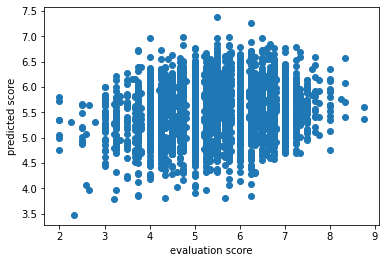

Epoch: 32/50, Train loss: 0.120415, Test loss: 1.070128, Accuracy: 36.83, difference: 0.824811
epoch 33 0.09637973616047225% train finish
epoch 33 9.734353352207698% train finish
epoch 33 19.372326968254924% train finish
epoch 33 29.01030058430215% train finish
epoch 33 38.64827420034938% train finish
epoch 33 48.2862478163966% train finish
epoch 33 57.92422143244382% train finish
epoch 33 67.56219504849106% train finish
epoch 33 77.20016866453828% train finish
epoch 33 86.8381422805855% train finish
epoch 33 96.47611589663273% train finish
epoch 33 train finish
epoch 33 0.3854492893278728% test finish
epoch 33 19.657913755721513% test finish
epoch 33 38.93037822211515% test finish
epoch 33 58.202842688508795% test finish
epoch 33 77.47530715490242% test finish
epoch 33 96.74777162129608% test finish


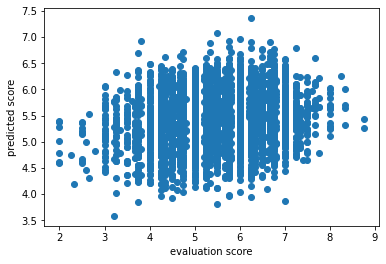

Epoch: 33/50, Train loss: 0.034652, Test loss: 1.090644, Accuracy: 36.18, difference: 0.839243
epoch 34 0.09637973616047225% train finish
epoch 34 9.734353352207698% train finish
epoch 34 19.372326968254924% train finish
epoch 34 29.01030058430215% train finish
epoch 34 38.64827420034938% train finish
epoch 34 48.2862478163966% train finish
epoch 34 57.92422143244382% train finish
epoch 34 67.56219504849106% train finish
epoch 34 77.20016866453828% train finish
epoch 34 86.8381422805855% train finish
epoch 34 96.47611589663273% train finish
epoch 34 train finish
epoch 34 0.3854492893278728% test finish
epoch 34 19.657913755721513% test finish
epoch 34 38.93037822211515% test finish
epoch 34 58.202842688508795% test finish
epoch 34 77.47530715490242% test finish
epoch 34 96.74777162129608% test finish


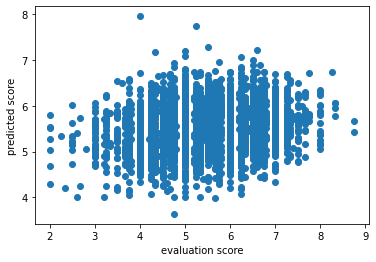

Epoch: 34/50, Train loss: 0.073353, Test loss: 1.071824, Accuracy: 36.86, difference: 0.831460
epoch 35 0.09637973616047225% train finish
epoch 35 9.734353352207698% train finish
epoch 35 19.372326968254924% train finish
epoch 35 29.01030058430215% train finish
epoch 35 38.64827420034938% train finish
epoch 35 48.2862478163966% train finish
epoch 35 57.92422143244382% train finish
epoch 35 67.56219504849106% train finish
epoch 35 77.20016866453828% train finish
epoch 35 86.8381422805855% train finish
epoch 35 96.47611589663273% train finish
epoch 35 train finish
epoch 35 0.3854492893278728% test finish
epoch 35 19.657913755721513% test finish
epoch 35 38.93037822211515% test finish
epoch 35 58.202842688508795% test finish
epoch 35 77.47530715490242% test finish
epoch 35 96.74777162129608% test finish


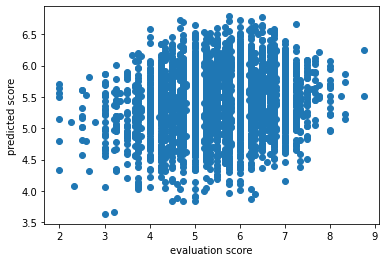

Epoch: 35/50, Train loss: 0.061631, Test loss: 1.071162, Accuracy: 36.81, difference: 0.833430
epoch 36 0.09637973616047225% train finish
epoch 36 9.734353352207698% train finish
epoch 36 19.372326968254924% train finish
epoch 36 29.01030058430215% train finish
epoch 36 38.64827420034938% train finish
epoch 36 48.2862478163966% train finish
epoch 36 57.92422143244382% train finish
epoch 36 67.56219504849106% train finish
epoch 36 77.20016866453828% train finish
epoch 36 86.8381422805855% train finish
epoch 36 96.47611589663273% train finish
epoch 36 train finish
epoch 36 0.3854492893278728% test finish
epoch 36 19.657913755721513% test finish
epoch 36 38.93037822211515% test finish
epoch 36 58.202842688508795% test finish
epoch 36 77.47530715490242% test finish
epoch 36 96.74777162129608% test finish


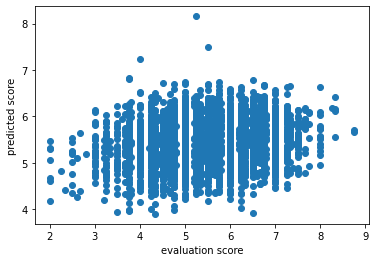

Epoch: 36/50, Train loss: 0.052983, Test loss: 1.044125, Accuracy: 37.36, difference: 0.815893
epoch 37 0.09637973616047225% train finish
epoch 37 9.734353352207698% train finish
epoch 37 19.372326968254924% train finish
epoch 37 29.01030058430215% train finish
epoch 37 38.64827420034938% train finish
epoch 37 48.2862478163966% train finish
epoch 37 57.92422143244382% train finish
epoch 37 67.56219504849106% train finish
epoch 37 77.20016866453828% train finish
epoch 37 86.8381422805855% train finish
epoch 37 96.47611589663273% train finish
epoch 37 train finish
epoch 37 0.3854492893278728% test finish
epoch 37 19.657913755721513% test finish
epoch 37 38.93037822211515% test finish
epoch 37 58.202842688508795% test finish
epoch 37 77.47530715490242% test finish
epoch 37 96.74777162129608% test finish


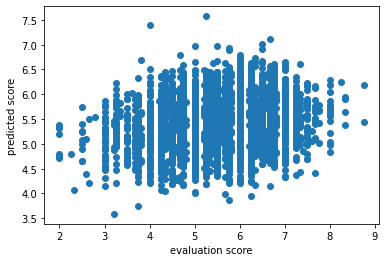

Epoch: 37/50, Train loss: 0.023113, Test loss: 1.079142, Accuracy: 36.40, difference: 0.833567
epoch 38 0.09637973616047225% train finish
epoch 38 9.734353352207698% train finish
epoch 38 19.372326968254924% train finish
epoch 38 29.01030058430215% train finish
epoch 38 38.64827420034938% train finish
epoch 38 48.2862478163966% train finish
epoch 38 57.92422143244382% train finish
epoch 38 67.56219504849106% train finish
epoch 38 77.20016866453828% train finish
epoch 38 86.8381422805855% train finish
epoch 38 96.47611589663273% train finish
epoch 38 train finish
epoch 38 0.3854492893278728% test finish
epoch 38 19.657913755721513% test finish
epoch 38 38.93037822211515% test finish
epoch 38 58.202842688508795% test finish
epoch 38 77.47530715490242% test finish
epoch 38 96.74777162129608% test finish


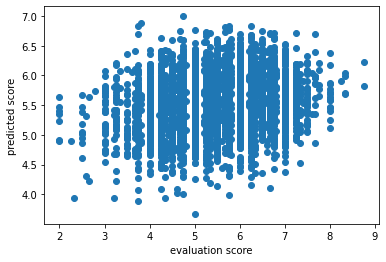

Epoch: 38/50, Train loss: 0.096098, Test loss: 1.041155, Accuracy: 37.51, difference: 0.817091
epoch 39 0.09637973616047225% train finish
epoch 39 9.734353352207698% train finish
epoch 39 19.372326968254924% train finish
epoch 39 29.01030058430215% train finish
epoch 39 38.64827420034938% train finish
epoch 39 48.2862478163966% train finish
epoch 39 57.92422143244382% train finish
epoch 39 67.56219504849106% train finish
epoch 39 77.20016866453828% train finish
epoch 39 86.8381422805855% train finish
epoch 39 96.47611589663273% train finish
epoch 39 train finish
epoch 39 0.3854492893278728% test finish
epoch 39 19.657913755721513% test finish
epoch 39 38.93037822211515% test finish
epoch 39 58.202842688508795% test finish
epoch 39 77.47530715490242% test finish
epoch 39 96.74777162129608% test finish


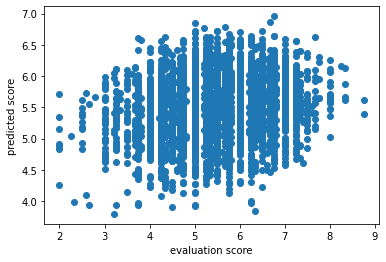

Epoch: 39/50, Train loss: 0.063144, Test loss: 1.045777, Accuracy: 37.08, difference: 0.818192
epoch 40 0.09637973616047225% train finish
epoch 40 9.734353352207698% train finish
epoch 40 19.372326968254924% train finish
epoch 40 29.01030058430215% train finish
epoch 40 38.64827420034938% train finish
epoch 40 48.2862478163966% train finish
epoch 40 57.92422143244382% train finish
epoch 40 67.56219504849106% train finish
epoch 40 77.20016866453828% train finish
epoch 40 86.8381422805855% train finish
epoch 40 96.47611589663273% train finish
epoch 40 train finish
epoch 40 0.3854492893278728% test finish
epoch 40 19.657913755721513% test finish
epoch 40 38.93037822211515% test finish
epoch 40 58.202842688508795% test finish
epoch 40 77.47530715490242% test finish
epoch 40 96.74777162129608% test finish


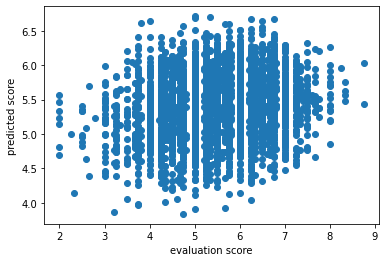

Epoch: 40/50, Train loss: 0.046964, Test loss: 1.044395, Accuracy: 36.93, difference: 0.820890
epoch 41 0.09637973616047225% train finish
epoch 41 9.734353352207698% train finish
epoch 41 19.372326968254924% train finish
epoch 41 29.01030058430215% train finish
epoch 41 38.64827420034938% train finish
epoch 41 48.2862478163966% train finish
epoch 41 57.92422143244382% train finish
epoch 41 67.56219504849106% train finish
epoch 41 77.20016866453828% train finish
epoch 41 86.8381422805855% train finish
epoch 41 96.47611589663273% train finish
epoch 41 train finish
epoch 41 0.3854492893278728% test finish
epoch 41 19.657913755721513% test finish
epoch 41 38.93037822211515% test finish
epoch 41 58.202842688508795% test finish
epoch 41 77.47530715490242% test finish
epoch 41 96.74777162129608% test finish


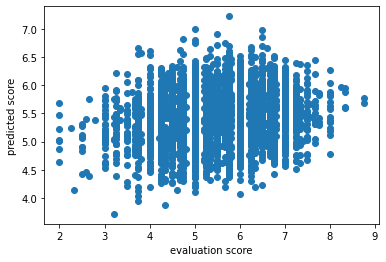

Epoch: 41/50, Train loss: 0.116710, Test loss: 1.052570, Accuracy: 37.08, difference: 0.823434
epoch 42 0.09637973616047225% train finish
epoch 42 9.734353352207698% train finish
epoch 42 19.372326968254924% train finish
epoch 42 29.01030058430215% train finish
epoch 42 38.64827420034938% train finish
epoch 42 48.2862478163966% train finish
epoch 42 57.92422143244382% train finish
epoch 42 67.56219504849106% train finish
epoch 42 77.20016866453828% train finish
epoch 42 86.8381422805855% train finish
epoch 42 96.47611589663273% train finish
epoch 42 train finish
epoch 42 0.3854492893278728% test finish
epoch 42 19.657913755721513% test finish
epoch 42 38.93037822211515% test finish
epoch 42 58.202842688508795% test finish
epoch 42 77.47530715490242% test finish
epoch 42 96.74777162129608% test finish


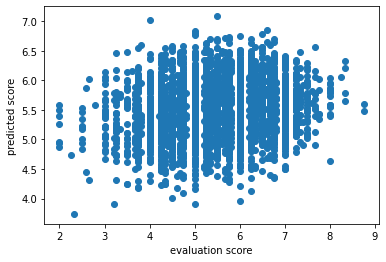

Epoch: 42/50, Train loss: 0.022985, Test loss: 1.036650, Accuracy: 37.89, difference: 0.810868
epoch 43 0.09637973616047225% train finish
epoch 43 9.734353352207698% train finish
epoch 43 19.372326968254924% train finish
epoch 43 29.01030058430215% train finish
epoch 43 38.64827420034938% train finish
epoch 43 48.2862478163966% train finish
epoch 43 57.92422143244382% train finish
epoch 43 67.56219504849106% train finish
epoch 43 77.20016866453828% train finish
epoch 43 86.8381422805855% train finish
epoch 43 96.47611589663273% train finish
epoch 43 train finish
epoch 43 0.3854492893278728% test finish
epoch 43 19.657913755721513% test finish
epoch 43 38.93037822211515% test finish
epoch 43 58.202842688508795% test finish
epoch 43 77.47530715490242% test finish
epoch 43 96.74777162129608% test finish


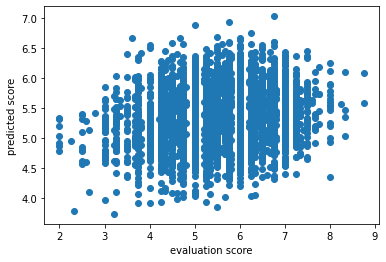

Epoch: 43/50, Train loss: 0.072171, Test loss: 1.081233, Accuracy: 35.53, difference: 0.838635
epoch 44 0.09637973616047225% train finish
epoch 44 9.734353352207698% train finish
epoch 44 19.372326968254924% train finish
epoch 44 29.01030058430215% train finish
epoch 44 38.64827420034938% train finish
epoch 44 48.2862478163966% train finish
epoch 44 57.92422143244382% train finish
epoch 44 67.56219504849106% train finish
epoch 44 77.20016866453828% train finish
epoch 44 86.8381422805855% train finish
epoch 44 96.47611589663273% train finish
epoch 44 train finish
epoch 44 0.3854492893278728% test finish
epoch 44 19.657913755721513% test finish
epoch 44 38.93037822211515% test finish
epoch 44 58.202842688508795% test finish
epoch 44 77.47530715490242% test finish
epoch 44 96.74777162129608% test finish


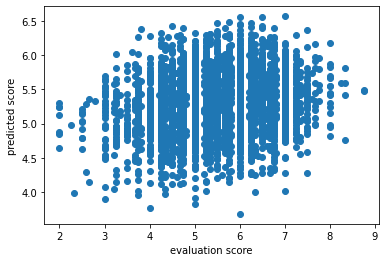

Epoch: 44/50, Train loss: 0.036040, Test loss: 1.074811, Accuracy: 36.28, difference: 0.834445
epoch 45 0.09637973616047225% train finish
epoch 45 9.734353352207698% train finish
epoch 45 19.372326968254924% train finish
epoch 45 29.01030058430215% train finish
epoch 45 38.64827420034938% train finish
epoch 45 48.2862478163966% train finish
epoch 45 57.92422143244382% train finish
epoch 45 67.56219504849106% train finish
epoch 45 77.20016866453828% train finish
epoch 45 86.8381422805855% train finish
epoch 45 96.47611589663273% train finish
epoch 45 train finish
epoch 45 0.3854492893278728% test finish
epoch 45 19.657913755721513% test finish
epoch 45 38.93037822211515% test finish
epoch 45 58.202842688508795% test finish
epoch 45 77.47530715490242% test finish
epoch 45 96.74777162129608% test finish


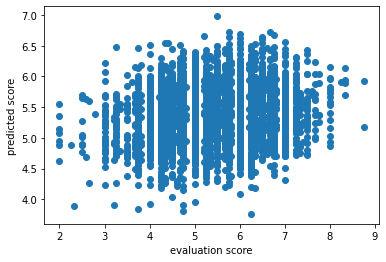

Epoch: 45/50, Train loss: 0.086611, Test loss: 1.063373, Accuracy: 36.67, difference: 0.827883
epoch 46 0.09637973616047225% train finish
epoch 46 9.734353352207698% train finish
epoch 46 19.372326968254924% train finish
epoch 46 29.01030058430215% train finish
epoch 46 38.64827420034938% train finish
epoch 46 48.2862478163966% train finish
epoch 46 57.92422143244382% train finish
epoch 46 67.56219504849106% train finish
epoch 46 77.20016866453828% train finish
epoch 46 86.8381422805855% train finish
epoch 46 96.47611589663273% train finish
epoch 46 train finish
epoch 46 0.3854492893278728% test finish
epoch 46 19.657913755721513% test finish
epoch 46 38.93037822211515% test finish
epoch 46 58.202842688508795% test finish
epoch 46 77.47530715490242% test finish
epoch 46 96.74777162129608% test finish


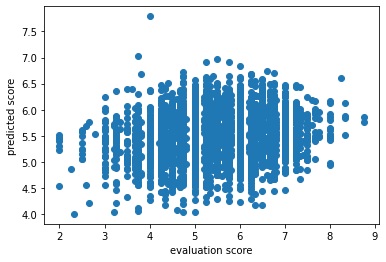

Epoch: 46/50, Train loss: 0.116572, Test loss: 1.046102, Accuracy: 37.00, difference: 0.819072
epoch 47 0.09637973616047225% train finish
epoch 47 9.734353352207698% train finish
epoch 47 19.372326968254924% train finish
epoch 47 29.01030058430215% train finish
epoch 47 38.64827420034938% train finish
epoch 47 48.2862478163966% train finish
epoch 47 57.92422143244382% train finish
epoch 47 67.56219504849106% train finish
epoch 47 77.20016866453828% train finish
epoch 47 86.8381422805855% train finish
epoch 47 96.47611589663273% train finish
epoch 47 train finish
epoch 47 0.3854492893278728% test finish
epoch 47 19.657913755721513% test finish
epoch 47 38.93037822211515% test finish
epoch 47 58.202842688508795% test finish
epoch 47 77.47530715490242% test finish
epoch 47 96.74777162129608% test finish


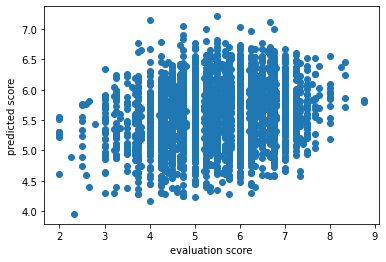

Epoch: 47/50, Train loss: 0.038366, Test loss: 1.056195, Accuracy: 36.79, difference: 0.822376
epoch 48 0.09637973616047225% train finish
epoch 48 9.734353352207698% train finish
epoch 48 19.372326968254924% train finish
epoch 48 29.01030058430215% train finish
epoch 48 38.64827420034938% train finish
epoch 48 48.2862478163966% train finish
epoch 48 57.92422143244382% train finish
epoch 48 67.56219504849106% train finish
epoch 48 77.20016866453828% train finish
epoch 48 86.8381422805855% train finish
epoch 48 96.47611589663273% train finish
epoch 48 train finish
epoch 48 0.3854492893278728% test finish
epoch 48 19.657913755721513% test finish
epoch 48 38.93037822211515% test finish
epoch 48 58.202842688508795% test finish
epoch 48 77.47530715490242% test finish
epoch 48 96.74777162129608% test finish


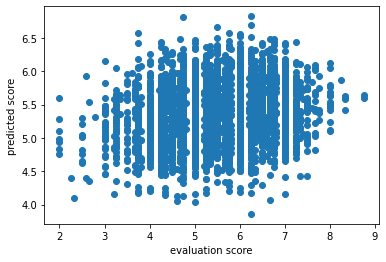

Epoch: 48/50, Train loss: 0.046826, Test loss: 1.039029, Accuracy: 36.45, difference: 0.821147
epoch 49 0.09637973616047225% train finish
epoch 49 9.734353352207698% train finish
epoch 49 19.372326968254924% train finish
epoch 49 29.01030058430215% train finish
epoch 49 38.64827420034938% train finish
epoch 49 48.2862478163966% train finish
epoch 49 57.92422143244382% train finish
epoch 49 67.56219504849106% train finish
epoch 49 77.20016866453828% train finish
epoch 49 86.8381422805855% train finish
epoch 49 96.47611589663273% train finish
epoch 49 train finish
epoch 49 0.3854492893278728% test finish
epoch 49 19.657913755721513% test finish
epoch 49 38.93037822211515% test finish
epoch 49 58.202842688508795% test finish
epoch 49 77.47530715490242% test finish
epoch 49 96.74777162129608% test finish


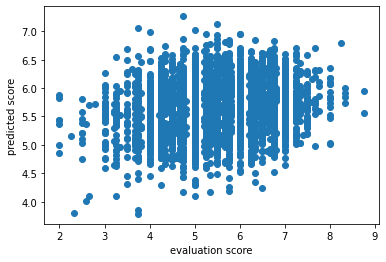

Epoch: 49/50, Train loss: 0.023217, Test loss: 1.066513, Accuracy: 36.45, difference: 0.823164
epoch 50 0.09637973616047225% train finish
epoch 50 9.734353352207698% train finish
epoch 50 19.372326968254924% train finish
epoch 50 29.01030058430215% train finish
epoch 50 38.64827420034938% train finish
epoch 50 48.2862478163966% train finish
epoch 50 57.92422143244382% train finish
epoch 50 67.56219504849106% train finish
epoch 50 77.20016866453828% train finish
epoch 50 86.8381422805855% train finish
epoch 50 96.47611589663273% train finish
epoch 50 train finish
epoch 50 0.3854492893278728% test finish
epoch 50 19.657913755721513% test finish
epoch 50 38.93037822211515% test finish
epoch 50 58.202842688508795% test finish
epoch 50 77.47530715490242% test finish
epoch 50 96.74777162129608% test finish


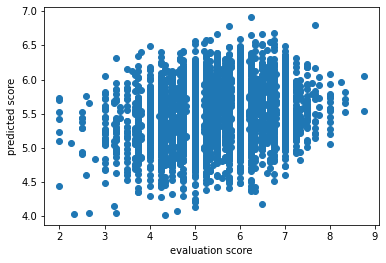

Epoch: 50/50, Train loss: 0.035026, Test loss: 1.005995, Accuracy: 37.56, difference: 0.804993
min loss: 0.9904174552254434
average_loss: 1.1790880406391073
average_accuracy: 36.10503493134182


In [16]:
import gc
gc.collect()              
torch.cuda.empty_cache()
train(model, params)

In [17]:

from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
+=1

SyntaxError: invalid syntax (1170883156.py, line 1)

## 테스트

In [ ]:
#@title
import cv2
class TestDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        cnt = 0
        year_image_path = overall_image_path
        # year_image_path = overall_image_path+"iclr"+year+"/"
        with jsonlines.open(f"drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl") as read_file:
            for line in read_file.iter():
                rating_dict[line['forum']] = line['rating']
        input_paths = os.listdir(year_image_path)
        input_paths.sort()
        for one_file_image_path in tqdm(input_paths, desc="make data set"):
            image_path = year_image_path + one_file_image_path + "/"
            before_add_size = len(self.image_list)
            imgs = glob.glob(image_path + "1.bin")
            imgs.sort()
            self.image_list.extend(imgs) # glob: 폴더 내의 파일 찾아줌
            rating = rating_dict[one_file_image_path]
            self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
            cnt += len(self.image_list)-before_add_size

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def img_list(self):
      print(self.image_list)

In [ ]:
image_path = "drive/Shareddrives/소종-논문/test/binary/occlusion/" 
dataset_file_name = 'iclr2021_dataset_test.pt'

In [ ]:
def test_make_save_data_set(image_path, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = TestDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, dataset_file_name)
  print("save data sets")

In [ ]:
test_make_save_data_set(image_path, dataset_file_name)

start to make data set
initialize data sets


FileNotFoundError: [Errno 2] No such file or directory: 'drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl'

In [ ]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(dataset_file_name)

test_size = len(dataset)
print("test size:", test_size)
# validation 

dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=False)

test size: 45


In [ ]:
import time
import datetime
from numpy import vstack

def test(model, params):
    total_start = time.time()
    loss_function=params["loss_function"]
    test_dataloader=dataloader
    device=params["device"]

    print("start train")
    print("test size:", test_size)

    # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    model.eval()
    
    for i, data in enumerate(test_dataloader, 0):
      print("i:", i)
      
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)

      print("size:",labels.size(0))
      print("label:", labels)
      

      # 결과값 연산
      outputs = model(inputs).squeeze()
      print("output:", outputs)
      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss

      # 학습 결과 출력
    print('Test loss: %.6f, Accuracy: %.2f' %(loss/total, 100*correct/total))

    total_elapsed_time = time.time() - total_start
    total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
test(model, params)

start train
test size: 45
i: 0
size: 32
label: tensor([8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500,
        5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        4.0000, 4.0000, 4.0000, 4.0000, 4.0000], device='cuda:0')
output: tensor([6.5816, 6.5845, 6.5476, 6.7172, 6.5774, 6.7502, 6.5787, 6.6212, 6.6677,
        5.2512, 4.5495, 5.4114, 5.3056, 5.1830, 4.2590, 5.1306, 4.4159, 5.0974,
        4.9216, 4.9011, 4.5559, 5.0236, 4.7439, 5.2108, 4.7982, 5.3017, 4.9362,
        4.7339, 4.6832, 5.0069, 4.9728, 4.8730], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


i: 1
size: 13
label: tensor([4., 4., 4., 4., 7., 7., 7., 7., 7., 7., 7., 7., 7.], device='cuda:0')
output: tensor([5.2232, 4.7544, 4.4490, 4.9124, 6.6159, 6.6060, 6.7244, 6.4929, 6.6800,
        6.5359, 6.5436, 6.2699, 6.6201], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Test loss: 2.917464, Accuracy: 31.11
Total Elapsed time is 0:00:00


## 안쓰는 코드

In [ ]:
lst = list()
with jsonlines.open("iclr2021_metadata.jsonl") as read_file:
  for line in read_file.iter():
    lst.append(float(line['rating']))
avg = sum(lst)/len(lst)
print(avg)

In [ ]:
avg_lst = [avg] * len(lst)
loss_function = nn.MSELoss()
test_loss = loss_function(torch.Tensor(lst).to(torch.float32), torch.Tensor(avg_lst).to(torch.float32)).item()
print(test_loss)

In [ ]:
total = 0
loss = 0
for i, data in enumerate(test_dataloader, 0):
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.type(torch.FloatTensor) 
  labels = labels.to(device)
  
  i_batch_size = labels.size(0)
  outputs = [avg] * i_batch_size
  outputs = torch.Tensor(outputs).to(device)
  total += i_batch_size
  test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
  loss += i_batch_size * test_loss

print('loss: %.6f' %(loss/total))

In [ ]:
 from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=True) # true 옵션으로 사전 학습된 모델을 로드

for param in resnet50.parameters():
    param.requires_grad = False

model2 = nn.Sequential(
    resnet50,
    nn.Flatten(),
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)
